In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline
import textwrap # for wrapping answer descriptions
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
import scrubbington as scrub
import evaluationton as evalu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [24]:
df = pd.read_json('../data/data.json')

In [25]:
from scrubbington import scrub_everything

In [26]:
feature_names = ['channels', 'fb_published', 'has_analytics', 'has_logo', 'num_order', 'num_payouts',
'sale_duration2', 'show_map', 'user_age', 'user_type', 'body_length']

In [27]:
df_test, y, X = scrub_everything(df, feature_names)
X

array([[    5,     0,     0, ...,    36,     1,  3852],
       [    0,     0,     0, ...,   149,     3,  3499],
       [    8,     0,     0, ...,   214,     3,  2601],
       ...,
       [   13,     1,     0, ...,    84,     4,   557],
       [    8,     0,     0, ...,   812,     3, 10873],
       [    0,     0,     0, ...,     0,     1,     0]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [29]:
X_train_len = X_train.shape[0]
X_test_len = X_test.shape[0]

y_train_len = y_train.shape[0]
y_test_len = y_test.shape[0]

print("X_train Data Count: {}".format(X_train_len))
print("y_train Data Count: {}".format(y_train_len))
print("X_test Data Count: {}".format(X_test_len))
print("y_test Data Count: {}".format(y_test_len))

print("\n\nSplit Percentage for Train Data: {}".format(X_train_len/(X_train_len + X_test_len)))

X_train Data Count: 10752
y_train Data Count: 10752
X_test Data Count: 3585
y_test Data Count: 3585


Split Percentage for Train Data: 0.7499476878007951


# Gradient Boost

In [30]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.919
Accuracy score (validation): 0.915
Learning rate:  0.1
Accuracy score (training): 0.943
Accuracy score (validation): 0.943
Learning rate:  0.25
Accuracy score (training): 0.959
Accuracy score (validation): 0.960
Learning rate:  0.5
Accuracy score (training): 0.962
Accuracy score (validation): 0.965
Learning rate:  0.75
Accuracy score (training): 0.963
Accuracy score (validation): 0.963
Learning rate:  1
Accuracy score (training): 0.962
Accuracy score (validation): 0.961


#### Learning rate 0.5 is chosen 

In [31]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=2,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

### Confusion Matrix

In [32]:
y_predictions = gb.predict(X_test)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()

In [34]:
print("True Negative: {}".format(tn))
print("True Positive: {}".format(tp))
print("False Negative: {}".format(fn))
print("False Positive: {}".format(fp))

True Negative: 3210
True Positive: 249
False Negative: 82
False Positive: 44


### Plotting Methods

In [35]:
def plot_roc(y_test, X_test, model, model_name):
    AUC = roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(model_name))
    plt.legend(loc="lower right");

In [36]:
def plot_profit_curve(scoring, profit_matrix, num_points=100):
    x_threshold, y_profit = scoring.profit_curve(num_points=num_points, profit_matrix=profit_matrix)
    
    fig, ax = plt.subplots()
    ax.plot(x_threshold, y_profit)
    
    ymax = max(y_profit)
    xpos = y_profit.index(ymax)
    xmax = x_threshold[xpos]
    
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=180,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    ax.set_ylim(min(y_profit), ymax*2)
    ax.set_xlabel('Threshold For Predicting Fraud')
    ax.set_ylabel('Profit')
    ax.set_title('Profit Curve')
    plt.show()

## Evaluating Standard RF

In [37]:
scoring = evalu.Scores(model=gb, X_test=X_test, y_test=y_test)
scoring.scores()

Accuracy: 0.9648535564853556
Precision 0.8498293515358362
Recall 0.7522658610271903
F1 0.798076923076923


In [51]:
false_pos = -100
true_pos  = 500
false_neg = 0
true_neg  = 0

profit_matrix = [[true_neg, false_pos],[false_neg, true_pos]]

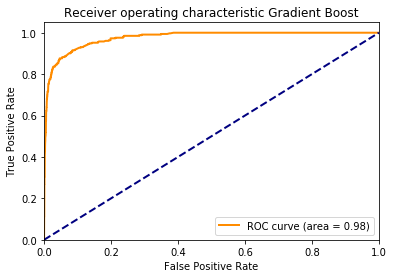

In [52]:
plot_roc(y_test, X_test, model=gb, model_name='Gradient Boost')

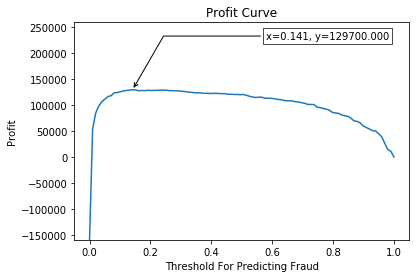

In [53]:
plot_profit_curve(scoring, profit_matrix, num_points=100)

### Using Evaluationton

In [54]:
scoring = evalu.Scores(model=gb, X_test=X_test, y_test=y_test)
scoring.scores()

Accuracy: 0.9648535564853556
Precision 0.8498293515358362
Recall 0.7522658610271903
F1 0.798076923076923
